In [20]:
import os
import urllib
import json
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image

In [21]:

data_dir = r'E:\code\capstone\data'
json_file = r'E:\code\capstone\project-1-at-2024-05-28-01-40-d3301fc8.json'
#num_classes = 81

In [22]:
# json
class CustomDataset(Dataset):
    def __init__(self, data_dir, json_file, transform=None):
        self.data_dir = data_dir
        with open(json_file, 'r', encoding='utf-8') as f:
            self.data = json.load(f)
        self.transform = transform

        # Create a set to store all unique labels
        all_labels = set()
        for item in self.data:
            if 'choice' in item:
                if isinstance(item['choice'], dict):
                    all_labels.update(item['choice']['choices'])
                else:
                    all_labels.add(item['choice'])

        # Create a dictionary to map labels to indices
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(all_labels))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path_encoded = item['image'].split('?d=')[-1]
        image_path = os.path.join(self.data_dir, urllib.parse.unquote(image_path_encoded))
        #print(f"Image path: {image_path}")
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        # Create a tensor of zeros with a length equal to the total number of classes
        num_classes = len(self.label_to_idx)
        labels = torch.zeros(num_classes, dtype=torch.float32)

        
        # Set the corresponding elements in the tensor to 1 for the labels present
        if 'choice' in item:
            if isinstance(item['choice'], dict):
                choices = item['choice']['choices']
            else:
                choices = [item['choice']]
            for choice in choices:
                label_idx = self.label_to_idx[choice]
                labels[label_idx] = 1



                
        return image, labels

    # def __getitem__(self, idx):
    #     item = self.data[idx]
    #     # if 'choice' not in item:
    #     #     # Skip the item if it doesn't have a 'choice' field
    #     #     return None

    #     image_path_encoded = item['image'].split('?d=')[-1]
    #     image_path = os.path.join(self.data_dir, urllib.parse.unquote(image_path_encoded))
    #     image = Image.open(image_path).convert('RGB')

    #     if self.transform:
    #         image = self.transform(image)

    #     # Create a tensor of zeros with a length equal to the total number of classes
    #     num_classes = len(self.label_to_idx)
    #     labels = torch.zeros(num_classes, dtype=torch.float32)

    #     if isinstance(item['choice'], dict):
    #         choices = item['choice']['choices']
    #     else:
    #         choices = [item['choice']]

    #     # Check if there is more than one label
    #     if len(choices) > 1:
    #         # Option 1: Skip the instance with multiple labels
    #         return None

    #         # Option 2: Keep only the first label
    #         # choice = choices[0]
    #         # label_idx = self.label_to_idx[choice]
    #         # labels[label_idx] = 1
    #         # return image, labels

    #     for choice in choices:
    #         label_idx = self.label_to_idx[choice]
    #         labels[label_idx] = 1

    #     return image, labels

In [23]:
# preprocess
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [24]:
# split data
from torch.utils.data import random_split

# Assuming you have your original dataset
dataset = CustomDataset(data_dir, json_file, transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for train, validation, and test sets
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [25]:
# model
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

class MultiLabelMobileNetV3(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelMobileNetV3, self).__init__()
        self.base_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

        
        """
        # Freeze pre-trained layers
        for param in self.base_model.parameters():
            param.requires_grad = False
        """
            
        self.base_model.classifier = nn.Sequential(
            nn.Linear(576, 1024),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes),
            # nn.Sigmoid()
            
        )

    def forward(self, x):
        return self.base_model(x)

In [26]:
# model
num_classes = len(dataset.label_to_idx)
model = MultiLabelMobileNetV3(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MultiLabelMobileNetV3(
  (base_model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
      

In [27]:
# Define loss function and optimizer
# criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Train the model
num_epochs = 20
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
early_stop_count = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    model.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}')

    # Evaluate on validation set
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_dataloader.dataset)
    print(f'Validation Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            break

print('-' * 10)
print('Training complete')

Epoch 1/20


KeyboardInterrupt: 

In [39]:
torch.save(model.state_dict(), 'mobilenetv3-nofreeze-105-loss.pth')

In [28]:
model.load_state_dict(torch.load('pth/mobilenetv3-nofreeze-105-loss.pth'))

<All keys matched successfully>

Test Accuracy: 0.9942
Hamming Loss: 0.0058
Precision: 0.9938, Recall: 0.9942, F1-Score: 0.9939
Mean Average Precision (mAP): 0.8699
Confusion Matrix:
[[96409   161]
 [  401   761]]


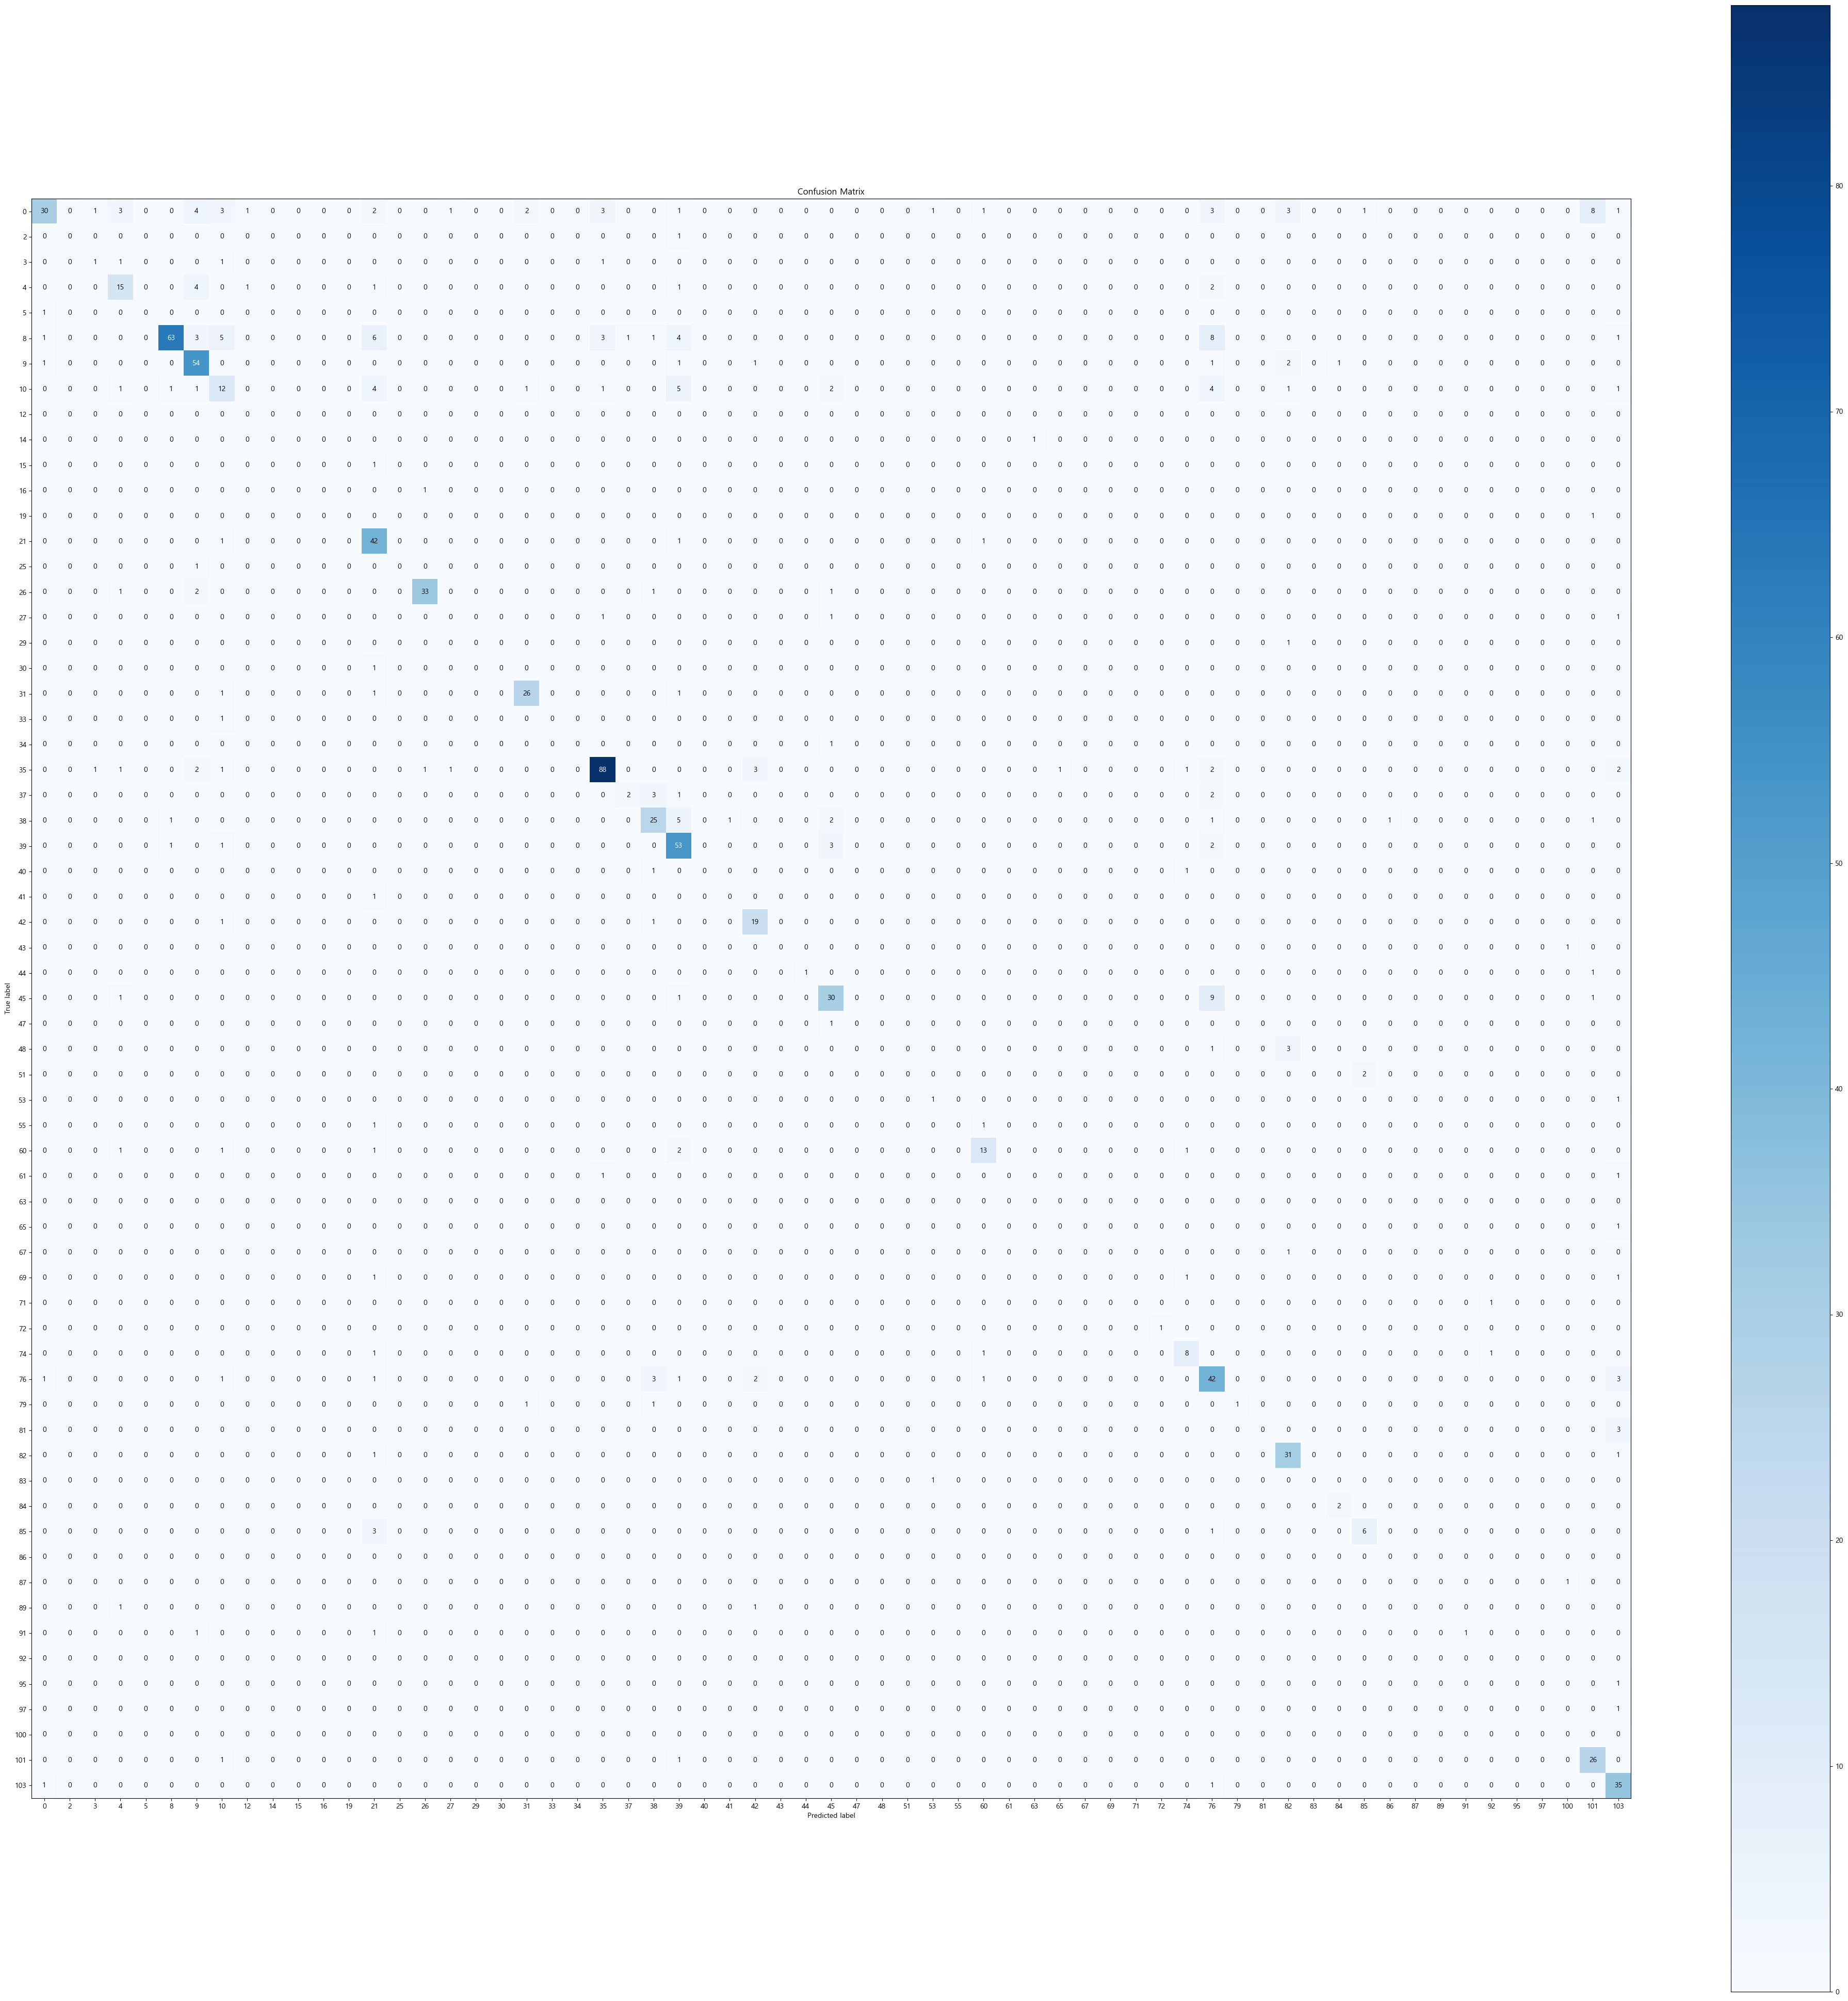

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

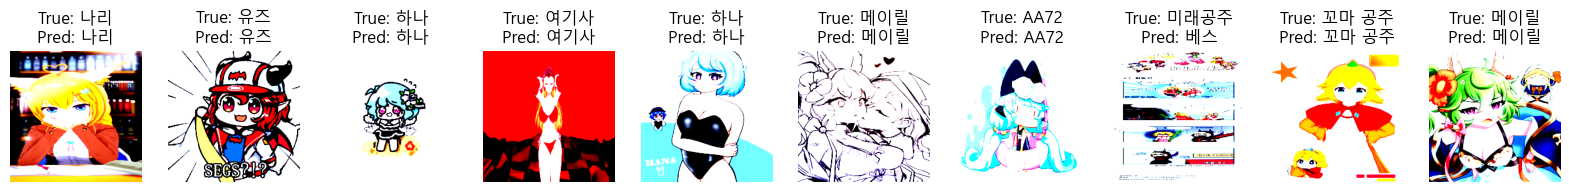

In [33]:
#test
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from sklearn.metrics import average_precision_score, hamming_loss
import scikitplot as skplt
import matplotlib.pyplot as plt
import random
# Add font
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


def test(model, test_dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    true_labels = []
    pred_labels = []
    images_list = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Get probabilities and binary predictions
            probs = torch.sigmoid(outputs)
            # preds = (probs > 0.5).float()
            preds = torch.zeros_like(probs)
            max_indices = torch.argmax(probs, dim=1, keepdim=True)
            preds.scatter_(1, max_indices, 1.0)
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            true_labels.extend(labels.cpu().numpy().argmax(axis=1))
            pred_labels.extend(preds.cpu().numpy().argmax(axis=1))
            # true_labels.extend(labels.cpu().numpy())
            # pred_labels.extend(preds.cpu().numpy())
            
            images_list.extend(images.cpu())

    all_probs = np.concatenate(all_probs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate precision, recall, and F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=1)

    # Calculate Hamming loss
    hamming_loss_value = hamming_loss(all_labels, all_preds)

    # Calculate mAP
    is_multi_label = len(all_probs.shape) > 1
    if is_multi_label:
        num_classes = all_probs.shape[1]
        ap_scores = []
        for c in range(num_classes):
            ap_scores.append(average_precision_score(all_labels[:, c], all_probs[:, c]))
        mean_ap = np.mean(ap_scores)
    else:
        mean_ap = average_precision_score(all_labels, all_probs)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels.ravel(), all_preds.ravel())

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Hamming Loss: {hamming_loss_value:.4f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}')
    print(f'Mean Average Precision (mAP): {mean_ap:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)

    # Plot confusion matrix
    skplt.metrics.plot_confusion_matrix(true_labels, pred_labels, figsize=(50, 50))
    plt.show()

    # Generate 10 random indices
    num_images_to_display = 10
    indices_to_display = random.sample(range(len(images_list)), num_images_to_display)

    num_images = len(indices_to_display)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i, idx in enumerate(indices_to_display):
        ax = axes[i]
        ax.imshow(images_list[idx].permute(1, 2, 0))  # Assuming images are in CHW format
        true_label = index_to_label[true_labels[idx]]
        pred_label = index_to_label[pred_labels[idx]]
        ax.set_title(f'True: {true_label}\nPred: {pred_label}')
        ax.axis('off')
    plt.show()

# Test the model
test(model, test_dataloader, device)

In [53]:
print(dataset.label_to_idx)

{'AA72': 0, 'KAI': 1, 'MK2': 2, 'MK99': 3, '가람': 4, '가브리엘': 5, '그레모리': 6, '기르가스': 7, '꼬마 공주': 8, '나리': 9, '남기사': 10, '네바': 11, '녹시아': 12, '돌프': 13, '라나': 14, '라피스': 15, '란': 16, '란팡': 17, '레아': 18, '레이': 19, '레이첼': 20, '로레인': 21, '로제타': 22, '루': 23, '루리': 24, '루시': 25, '루피나': 26, '리리스': 27, '리사': 28, '리에': 29, '린': 30, '마리나': 31, '마리아': 32, '마리안': 33, '마빈': 34, '메이릴': 35, '모리안': 36, '미래 공주': 37, '미래 기사': 38, '미래공주': 39, '미스 크롬': 40, '미야': 41, '바리': 42, '발렌시아': 43, '베로니카': 44, '베스': 45, '벨리알': 46, '비슈바크': 47, '비앙카': 48, '산타': 49, '샤피라': 50, '샬롯': 51, '세실': 52, '소히': 53, '스미레': 54, '스칼렛': 55, '시아': 56, '신틸라': 57, '아가사': 58, '아라': 59, '아라벨': 60, '아오바': 61, '아이리스': 62, '아이샤': 63, '아카유키': 64, '안드라스': 65, '안드로이드': 66, '알레프': 67, '에리나': 68, '에바': 69, '에이미': 70, '에일리': 71, '엔지': 72, '엘레노아': 73, '엘비라': 74, '엠마': 75, '여기사': 76, '오그마': 77, '오딜': 78, '오르카': 79, '요정': 80, '유나': 81, '유즈': 82, '유진': 83, '은하': 84, '카리나': 85, '카마엘': 86, '카밀라': 87, '칸나': 88, '캐럴': 89, '캐서린': 90, '코코': 91, '크레이그': 92, '크

In [ ]:
image_path = r"E:\code\capstone\data\pixiv\95604048\95604048_p24.png"
image = Image.open(image_path).convert('RGB')

# Apply the same transformations you used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

preprocessed_image = transform(image).unsqueeze(0)  # Add a batch dimension

In [ ]:
with torch.no_grad():
    outputs = model(preprocessed_image.to(device))

In [ ]:
threshold = 0.5
predicted_labels = (outputs > threshold).nonzero().squeeze(1)
print(f"Predicted Labels: {predicted_labels}")

Predicted Labels: tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)


In [ ]:
# Convert tensor to list of tuples containing (row_index, column_index)
predicted_labels_list = predicted_labels.tolist()

# Iterate over each prediction and print the corresponding label name
for row, col in predicted_labels_list:
    if col in dataset.label_to_idx.values():
        label_name = next(key for key, value in dataset.label_to_idx.items() if value == col)
        print(f"Predicted Label: {label_name}")

In [ ]:
print("Classifier Layer:")
for name, param in model.base_model.classifier.named_parameters():
    print(f"{name}: {param.requires_grad}")

print("\nConvolutional Layers:")
for name, param in model.base_model.features.named_parameters():
    print(f"{name}: {param.requires_grad}")

Classifier Layer:
0.weight: True
0.bias: True
3.weight: True
3.bias: True

Convolutional Layers:
0.0.weight: False
0.1.weight: False
0.1.bias: False
1.block.0.0.weight: False
1.block.0.1.weight: False
1.block.0.1.bias: False
1.block.1.fc1.weight: False
1.block.1.fc1.bias: False
1.block.1.fc2.weight: False
1.block.1.fc2.bias: False
1.block.2.0.weight: False
1.block.2.1.weight: False
1.block.2.1.bias: False
2.block.0.0.weight: False
2.block.0.1.weight: False
2.block.0.1.bias: False
2.block.1.0.weight: False
2.block.1.1.weight: False
2.block.1.1.bias: False
2.block.2.0.weight: False
2.block.2.1.weight: False
2.block.2.1.bias: False
3.block.0.0.weight: False
3.block.0.1.weight: False
3.block.0.1.bias: False
3.block.1.0.weight: False
3.block.1.1.weight: False
3.block.1.1.bias: False
3.block.2.0.weight: False
3.block.2.1.weight: False
3.block.2.1.bias: False
4.block.0.0.weight: False
4.block.0.1.weight: False
4.block.0.1.bias: False
4.block.1.0.weight: False
4.block.1.1.weight: False
4.block